# Preliminary

All this work is copy of insane tutorial by Andrej Karpathy with some student's comments. Check out his youtube, github, and anything there is!

https://www.youtube.com/watch?v=kCc8FmEb1nY&ab_channel=AndrejKarpathy

Transformer was a neural network deseign developed first in paper:

https://arxiv.org/abs/1706.03762

Transformer paper also uses knowledge of deep residual connections development from here:

https://arxiv.org/abs/1512.03385

While scaling model, to prevent overfitting, we use a dropout strategy developed in:

https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf

## Some editorial notes

In case of text generation. We can think of it as a question "What token comes next in a series of given context?", thus for neural net this is a 'classification' problem. For given token database which of them is represented by the context you see?

In this tutorial Andrej developed a language generation model. It differs from original paper in some aspects. The key one is that the original transformer was developed for machine translation task, hence it used encoder-decoder structure. This example is just a decoder. Both these components are structured in similar way, and their cooperation is easy to understand once the Self-Attention mechanism is understood.

It have been 6 years since 'Attention is all you need' was written. A lot have changed during that time. Now living in the era of Transformer based models, it becomes key to understand what is the mechanism that empowers them so much. Just picture this, neural nets are trivial subject from the mathematical point of view, they were discovered long long ago, but never before there was so much hype for them. Why? Well, it was always known how powerful they can be, but computation was extremly resource consuming, and the architecture( of any kind) had its limitations. Recent advancements in computation allowed scientist to work more on them, creating state of art models. Not only the neural nets, but all sorts of decision making alorithms. Success was close, but something was still lacking to let them take over the world. It turned out that the attention was all they needed...

## Download tinyshakespeare and load it

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-04-11 08:34:57--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2023-04-11 08:34:57 (8.79 MB/s) - 'input.txt' saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [7]:
print("Length of dataset in characters(which will be our tokens): ", len(text))

Length of dataset in characters(which will be our tokens):  1115394


## Vocab creation for tokenization

In [9]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print('Number of characters in vocabulary: ' + str(vocab_size))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Number of characters in vocabulary: 65


## Vocab mapping into integers

Now we create a simple tokenization process. It is a good exercise to use different implementations, where tokens are subwords. Search huggingface! ... or <b>take TIKTOKEN like Andrej suggested.

In [10]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [11]:
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


# Initial work on dataset

## Dataset encoding with previously created vocab mapping

In [15]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


We encoded whole dataset into a single tensor which size corresponds to lenght of original dataset(number of characters). And each element is a representation of a character given by encode mapping.

In fact what we just did is that we tokenized the dataset. Remember in our case <b>character == token</b> ;)

## Dummy data split

In [18]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Context(time dimension) explanation

We setup the size of context(number of preceding tokens) on which the model will try to predict the next token in series.

In [19]:
context_size = 8
train_data[:context_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [28]:
x = train_data[:context_size]
y = train_data[1:context_size+1]
for i,t in enumerate(range(context_size)):
    context = x[:t+1]
    target = y[t]
    print(str(i+1) + f". When input is {context} the target token is: {target}.")

1. When input is tensor([18]) the target token is: 47.
2. When input is tensor([18, 47]) the target token is: 56.
3. When input is tensor([18, 47, 56]) the target token is: 57.
4. When input is tensor([18, 47, 56, 57]) the target token is: 58.
5. When input is tensor([18, 47, 56, 57, 58]) the target token is: 1.
6. When input is tensor([18, 47, 56, 57, 58,  1]) the target token is: 15.
7. When input is tensor([18, 47, 56, 57, 58,  1, 15]) the target token is: 47.
8. When input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target token is: 58.


We train on each of 8 of this tensors for given input tensor to make model used to recognize different context sizes.

## Batching

In [39]:
torch.manual_seed(2137)
batch_size = 4 # how many independent sequences will we process in parallel?
context_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_size, (batch_size,)) #batch_size number of random offsets
    #Stack appends rows to tensor. The size of it here is 4x8.
    x = torch.stack([data[i:i+context_size] for i in ix]) 
    y = torch.stack([data[i+1:i+context_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for i,b in enumerate(range(batch_size)): # batch dimension
    print('BATCH ' + str(i+1))
    for j,t in enumerate(range(context_size)): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(str(j+1)+ f" When input is {context.tolist()} the target token is: {target}.")

inputs:
torch.Size([4, 8])
tensor([[47, 56,  1, 54, 56, 53, 54, 53],
        [42,  8,  0,  0, 30, 27, 25, 17],
        [ 1, 47, 52,  1, 58, 46, 43,  1],
        [ 1, 54, 43, 53, 54, 50, 43,  6]])
targets:
torch.Size([4, 8])
tensor([[56,  1, 54, 56, 53, 54, 53, 56],
        [ 8,  0,  0, 30, 27, 25, 17, 27],
        [47, 52,  1, 58, 46, 43,  1, 53],
        [54, 43, 53, 54, 50, 43,  6,  1]])
----
BATCH 1
1 When input is [47] the target token is: 56.
2 When input is [47, 56] the target token is: 1.
3 When input is [47, 56, 1] the target token is: 54.
4 When input is [47, 56, 1, 54] the target token is: 56.
5 When input is [47, 56, 1, 54, 56] the target token is: 53.
6 When input is [47, 56, 1, 54, 56, 53] the target token is: 54.
7 When input is [47, 56, 1, 54, 56, 53, 54] the target token is: 53.
8 When input is [47, 56, 1, 54, 56, 53, 54, 53] the target token is: 56.
BATCH 2
1 When input is [42] the target token is: 8.
2 When input is [42, 8] the target token is: 0.
3 When input is [42,

This gives us 32 independent training examples for the model. Each batch was chosen as a random dataset slice of lenght context_size. And within each we have context_size number of training examples of different lenght. So 4x8 = 32 unique examples.

# Into the language models we go

Bigram model is not complex example of language model, which can give us the intuition of what we will be dealing with in the future. For instance we can see how the general structure looks, and what components are included in it.

## Bigram model overview

In [43]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(2137)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        #basic torch implementation, super is used to avoid issues with class inheretance
        super().__init__() 
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # C is channel, the row selected by lookup on the embedding table.
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            #logits reshaping for cross entropy calculation, this is just a programming thing ;)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.4554, grad_fn=<NllLossBackward0>)

.VsjVmn.VEJLVoWVnR$By$nbXVmzNOAokbakB,.SdviEfdfw
r$lfEWIMFqmBdTbmxDFzYvG..3TaKw?jpnbeEzfPeQJWXfN$nzM


Random output, because model is not trainted yet. Also the loss is higher than the one we can calculate theoreticly, beacuse there is entropy involved. You can also look at it this way. The loss right now depends on seed. 

### Less noisy loss calculation

In [58]:
@torch.no_grad() #this tells torch that we will never call back on what is below, so it does not have to store info about it
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

### Optimizer and training loop

In [59]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

Here we give big learning rate, because the model is very small

In [62]:
batch_size = 32
eval_interval = 300
eval_iters = 200
vlosses = []
for steps in range(10000): # increase number of steps for good results... 
    if steps % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        vlosses.append(losses['val'])
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

step 0: train loss 2.4549, val loss 2.4900
step 300: train loss 2.4542, val loss 2.5008
step 600: train loss 2.4529, val loss 2.4904
step 900: train loss 2.4552, val loss 2.4833
step 1200: train loss 2.4477, val loss 2.4960
step 1500: train loss 2.4391, val loss 2.4754
step 1800: train loss 2.4440, val loss 2.4866
step 2100: train loss 2.4462, val loss 2.4809
step 2400: train loss 2.4495, val loss 2.4983
step 2700: train loss 2.4583, val loss 2.4933
step 3000: train loss 2.4438, val loss 2.4900
step 3300: train loss 2.4466, val loss 2.4841
step 3600: train loss 2.4558, val loss 2.4936
step 3900: train loss 2.4515, val loss 2.4974
step 4200: train loss 2.4499, val loss 2.4860
step 4500: train loss 2.4552, val loss 2.4841
step 4800: train loss 2.4571, val loss 2.4901
step 5100: train loss 2.4653, val loss 2.4855
step 5400: train loss 2.4424, val loss 2.4930
step 5700: train loss 2.4557, val loss 2.4975
step 6000: train loss 2.4570, val loss 2.4838
step 6300: train loss 2.4532, val loss 2

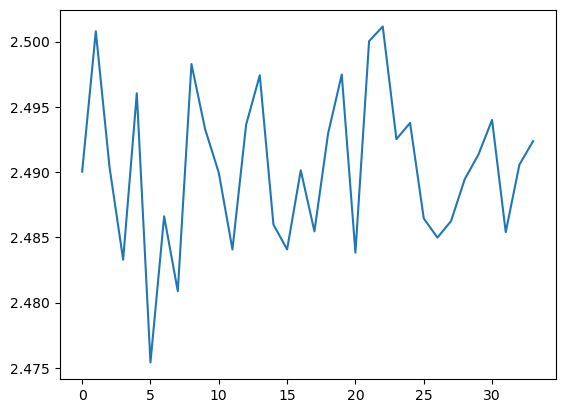

In [63]:
from matplotlib.pyplot import plot
plot(range(len(vlosses)),vlosses)

In [64]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


S:

Thive co at Win;
Pr qupteve patothin ied oucusur ke spequgsh mor, t prt heaneinio tintou is ondoulyonothithoul.
S:
AMIXFushton mesthelll'Thad shthedou r.
Hilaner lf se oy
I'dor, the thadeige talendowil, deer s any, belit whoveier y I gre-
Cu?
The, Hatseat ug.

Le,
A bs, singhche blerant beps ' betu infous yord's:
Br k r, h so at tof grdaintoit chushy d sped oklse ane b y g.

BOVOF:
Thaintobok me ear the I hen
INEd maid; Gostivinitifeled the I thasle Yorsicotr'er, Cocoreen,
Ansarenoured uk-te


# Self-attention

## Mathematics

All examples below illustrate how matrix multiplication can help us include information about precceding tokens in generating new ones. It is all about building weight matrix telling us how much information we want to pass, and it should be lower triangular one, because we don't want to generate tokens basing on future. We predict future from the past! The last thing in this section is the softmax implementation which is the best. If you understand it, skip.

In [65]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [66]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [67]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [68]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [70]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) #we cut off the future
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

## Into the attention world

In [78]:
# version 4: self-attention!
torch.manual_seed(2137)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

<b> Andrej's notes: <br>
Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below    

In [72]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [73]:
k.var()

tensor(1.0449)

In [74]:
q.var()

tensor(1.0700)

In [75]:
wei.var()

tensor(1.0918)

In [76]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [77]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

Example above illustrates the importance of scaling with the head size, to achive variance close to 1 before the softmax. If we don't do that the results is becoming similar to one hot encoding. Meaning the biggest number will have the biggest weight and as the result the token will talk only with the one token that happens to be most important to it, losing all other information!

# Transformers

## TBC

## Layer normalization

Layers are normalized with use of torch implementation:

https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [79]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

Multihead attention is a case of using multiple attention heads in parallel. With different channel sizes. What is means that with create more communication ways between heads searching for different types of information. I the end we concatenate results to get our prediction on wegihts.

# Final model

In [80]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(2137)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.3312, val loss 4.3354
step 100: train loss 2.6470, val loss 2.6729
step 200: train loss 2.4964, val loss 2.4974
step 300: train loss 2.4210, val loss 2.4180
step 400: train loss 2.3554, val loss 2.3702
step 500: train loss 2.2942, val loss 2.3106
step 600: train loss 2.2435, val loss 2.2564
step 700: train loss 2.1953, val loss 2.2201
step 800: train loss 2.1618, val loss 2.1925
step 900: train loss 2.1181, val loss 2.1677
step 1000: train loss 2.0859, val loss 2.1304
step 1100: train loss 2.0605, val loss 2.1039
step 1200: train loss 2.0298, val loss 2.0835
step 1300: train loss 2.0104, val loss 2.0657
step 1400: train loss 1.9843, val loss 2.0547
step 1500: train loss 1.9572, val loss 2.0307
step 1600: train loss 1.9370, val loss 2.0094
step 1700: train loss 1.9203, val loss 2.0136
step 1800: train loss 1.9086, val loss 1.9963
step 1900: train loss 1.8946, val loss 1.9777
step 2000: train loss 1.8735, val loss 1.9709
step 2100: train loss 1.